### Import Libraries

In [1]:
import pandas as pd
import pathlib
from joblib import load
from matplotlib import pyplot as plt

import sys
sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import class_PR_curves

### Load models and datasets

In [2]:
model_dir = pathlib.Path("../2.train_model/models/")
log_reg_model_path = pathlib.Path(f"{model_dir}/log_reg_model.joblib")
log_reg_model = load(log_reg_model_path)
shuffled_baseline_log_reg_model_path = pathlib.Path(f"{model_dir}/shuffled_baseline_log_reg_model.joblib")
shuffled_baseline_log_reg_model = load(shuffled_baseline_log_reg_model_path)

# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/training_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

train_data = get_dataset(features_dataframe, data_split_indexes, "train")
test_data = get_dataset(features_dataframe, data_split_indexes, "test")

save_dir = pathlib.Path("evaluations/class_precision_recall_curves/")
save_dir.mkdir(parents=True, exist_ok=True)

### Evaluate Each Model on Each Dataset

Evaluating model on dataset test


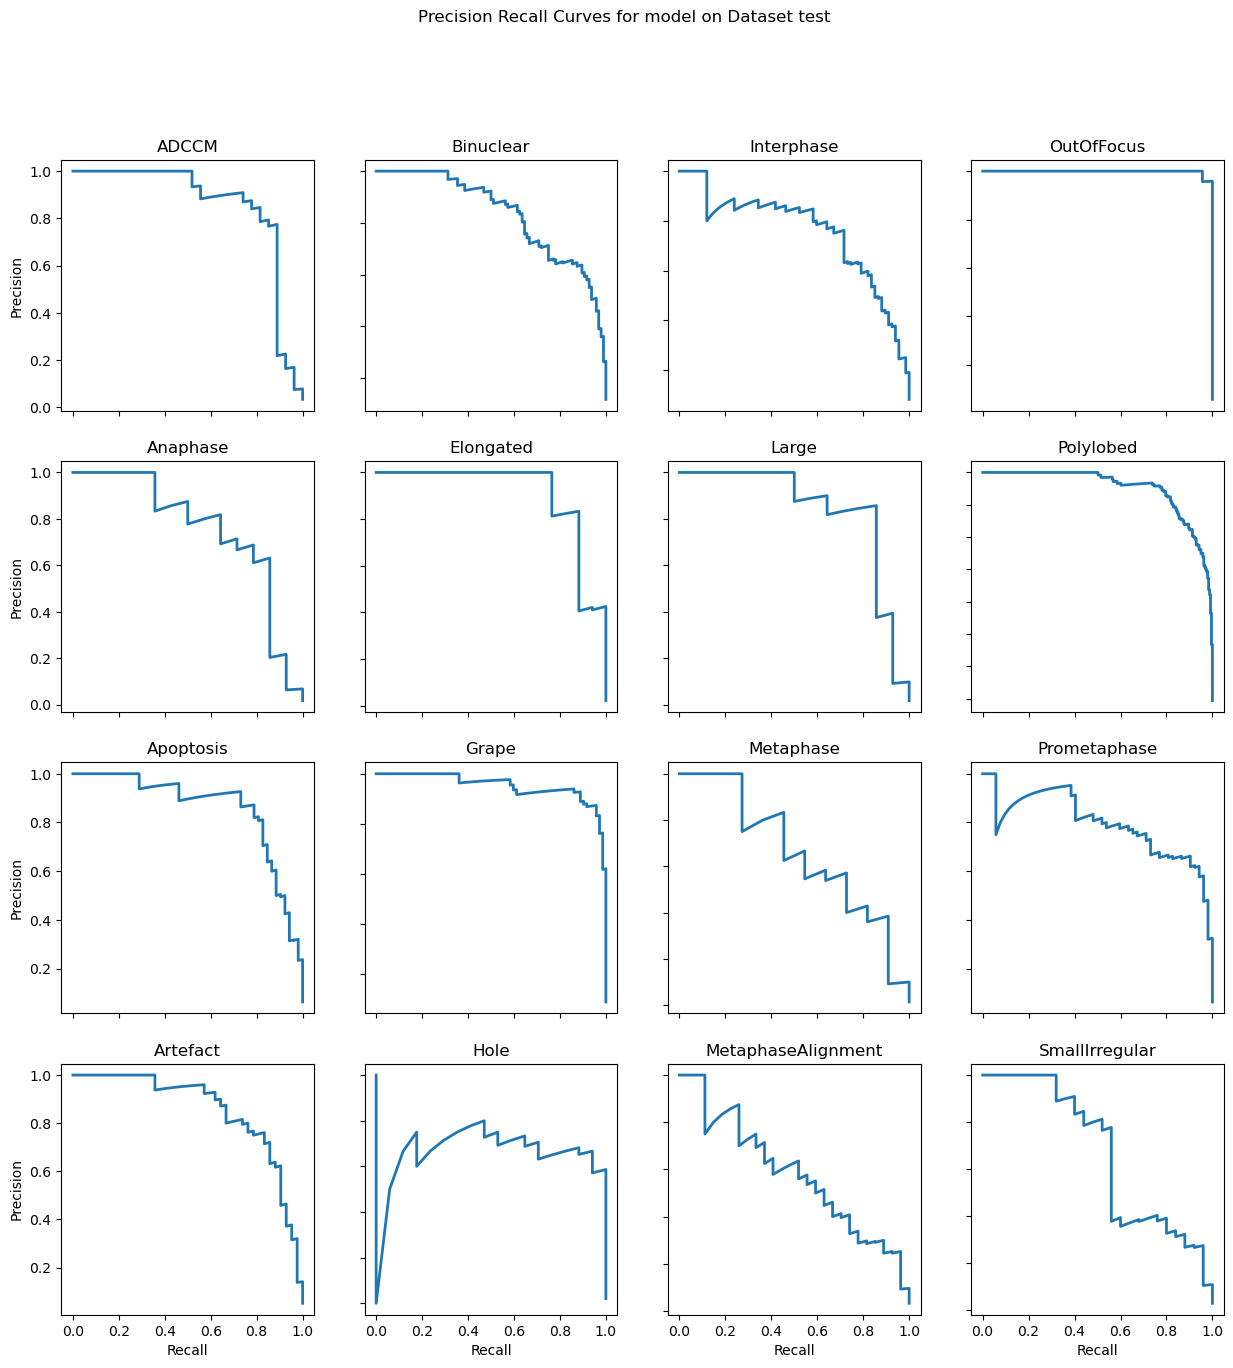

Evaluating model on dataset train


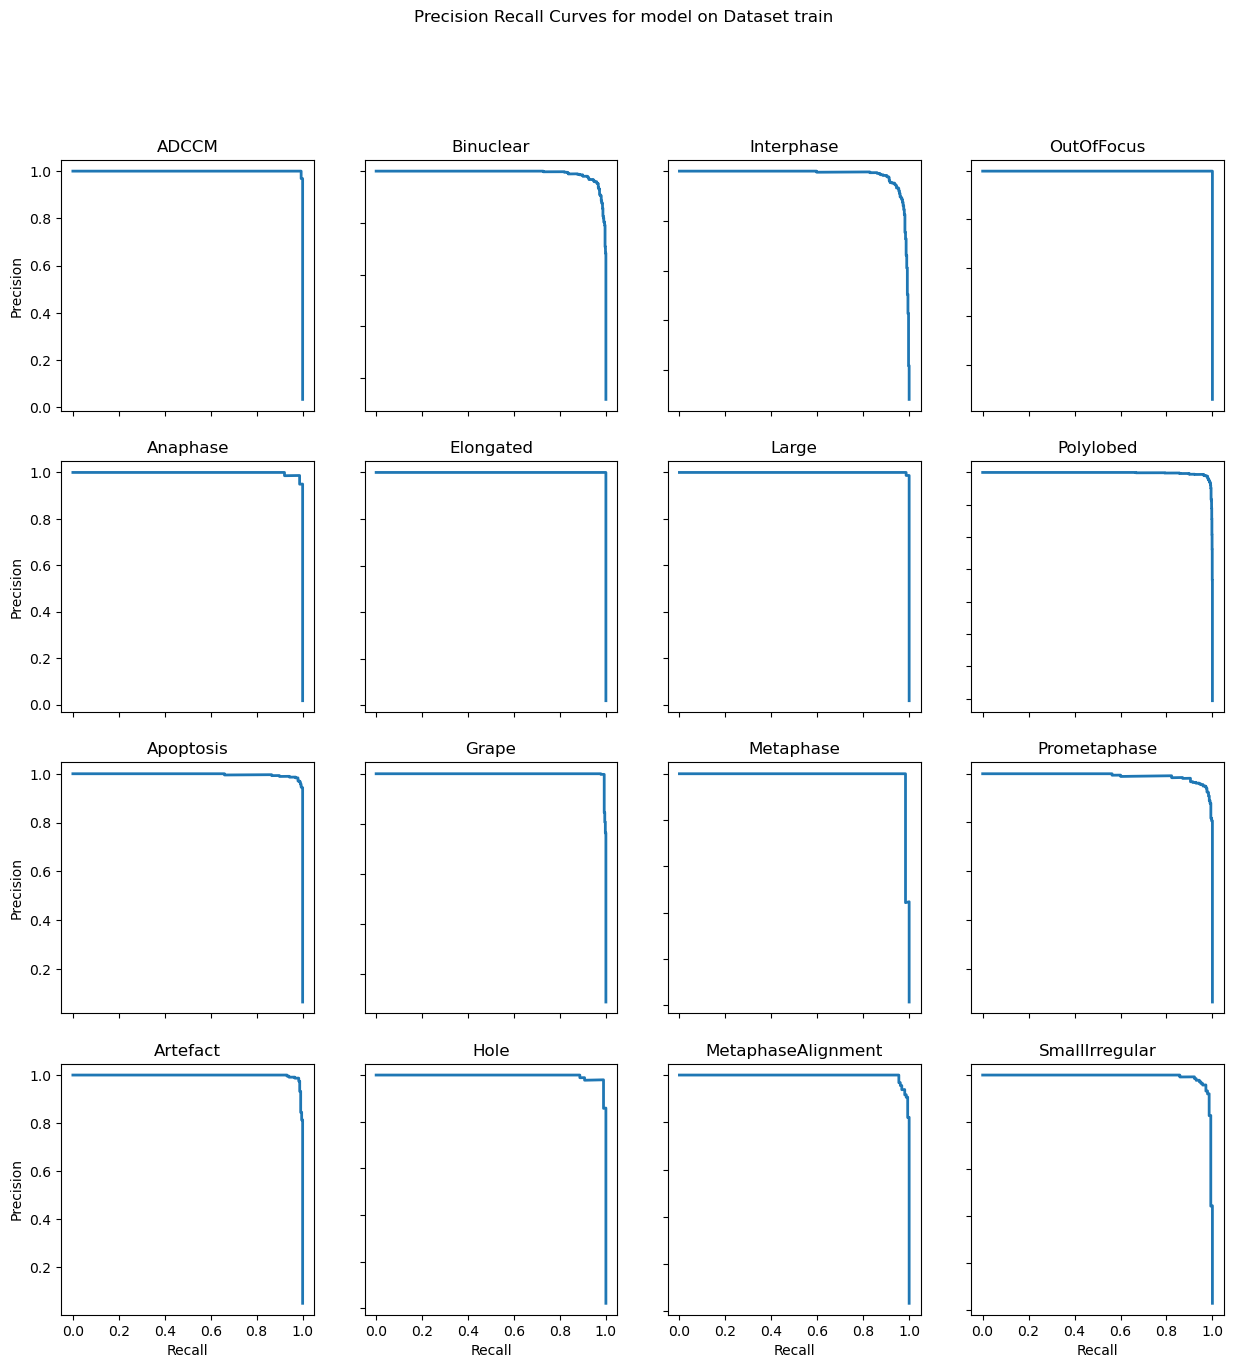

Evaluating shuffled_baseline_model on dataset test


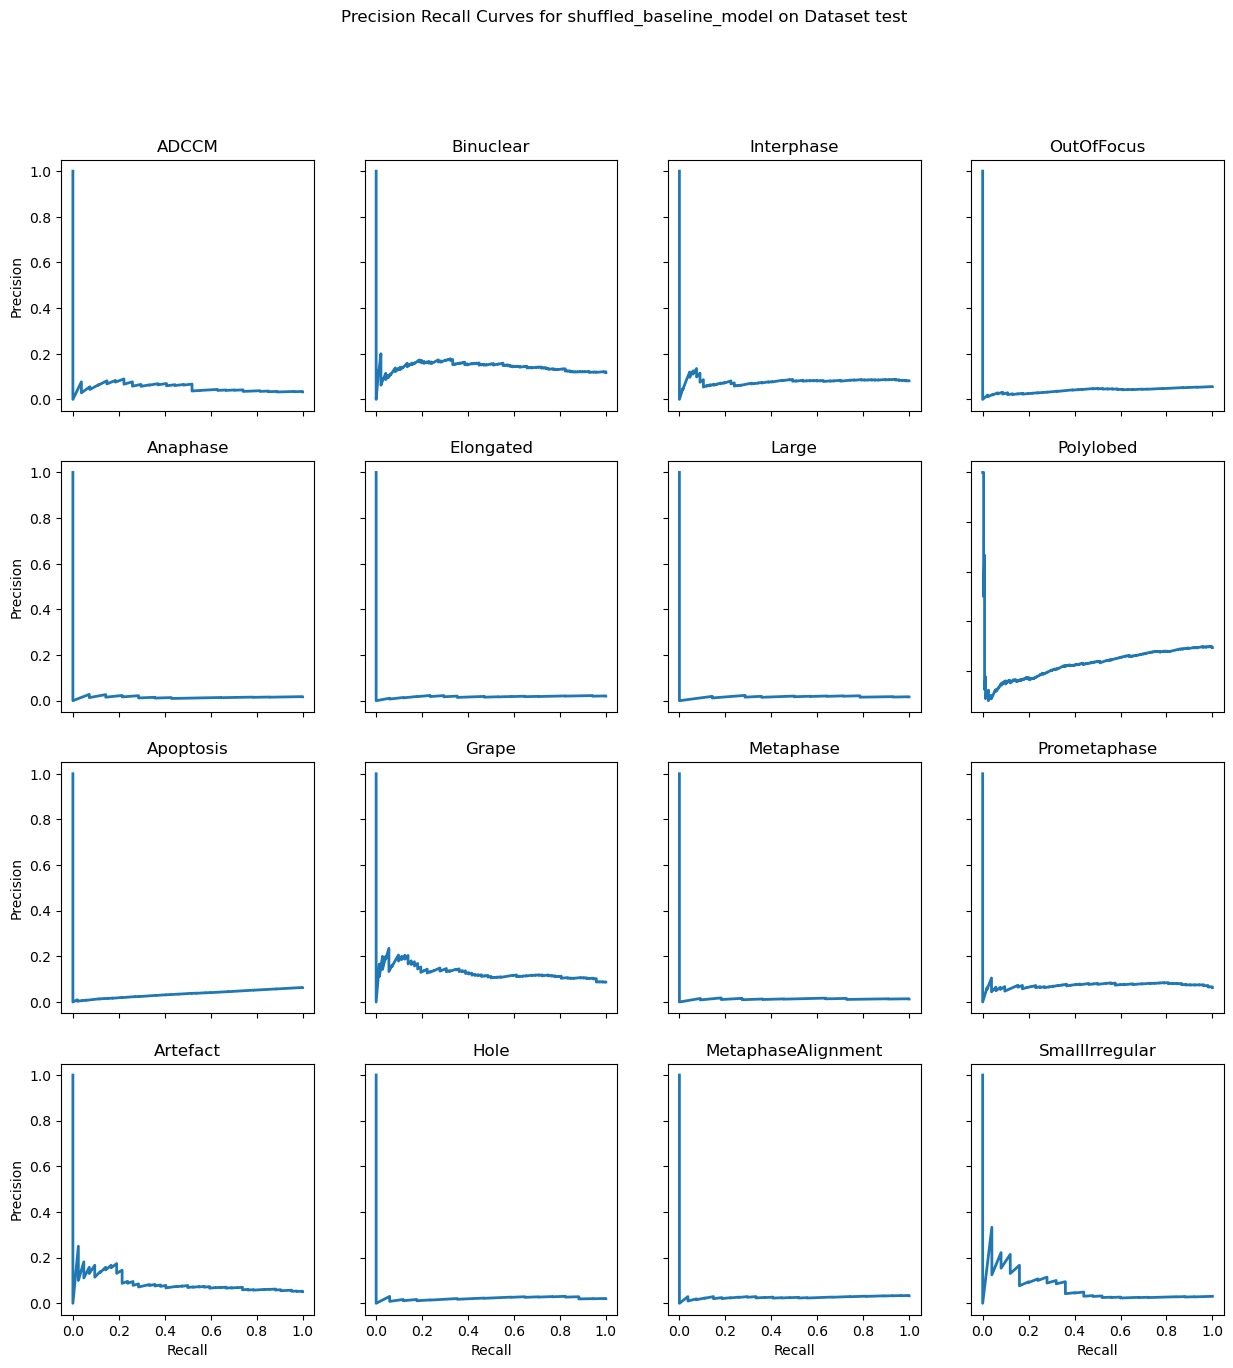

Evaluating shuffled_baseline_model on dataset train


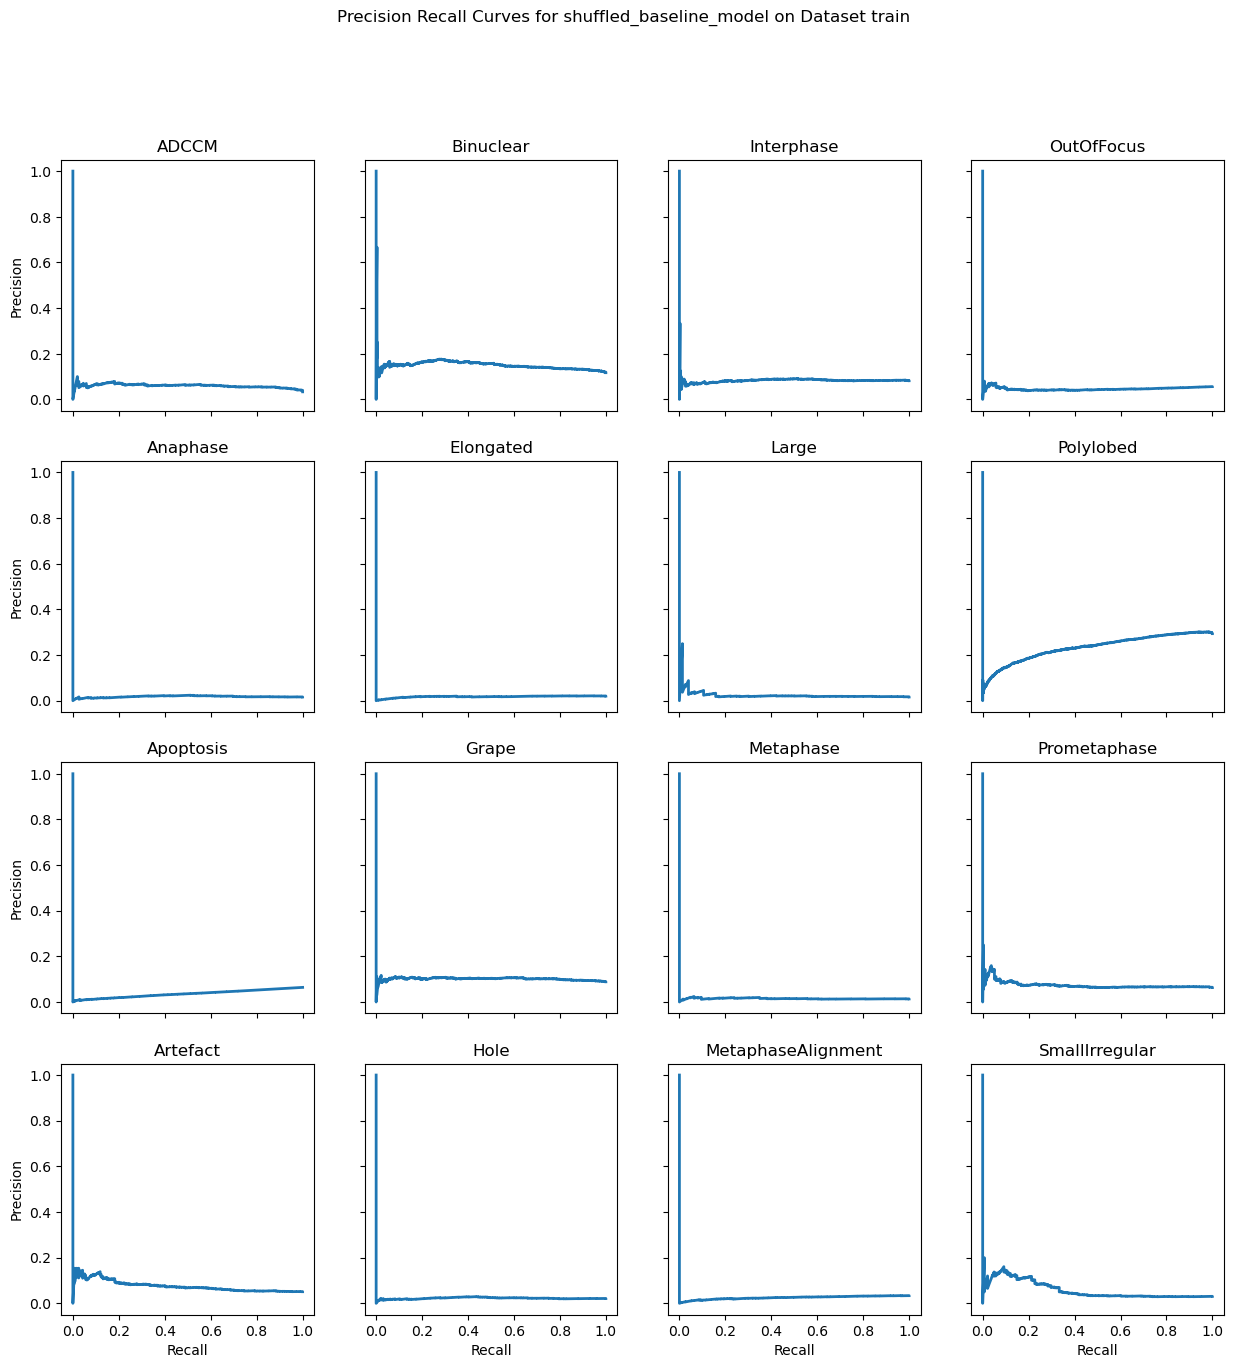

In [3]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_class_PR_curves = []

# iterate through each model (final model, shuffled baseline model, etc)
for model_path in models_dir.iterdir():
    model = load(model_path)
    model_name = model_path.name.replace("log_reg_","").replace(".joblib","")
    
    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(f"Evaluating {model_name} on dataset {label}")
        
        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        
        # get class PR curve data and show curve
        fig, PR_data = class_PR_curves(data, model)
        fig.suptitle(f"Precision Recall Curves for {model_name} on Dataset {label}")
        plt.show()
        
        # add data split column to indicate which dataset scores are from (train, test, etc)
        PR_data["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        PR_data["shuffled"] = "shuffled" in model_name
        # add this score data to the tidy scores compiling list
        compiled_class_PR_curves.append(PR_data)

### Save PR curves from each evaluation

In [4]:
# compile list of tidy data into one dataframe
compiled_class_PR_curves = pd.concat(compiled_class_PR_curves).reset_index(drop=True)

# specify results directory
class_PR_curves_dir = pathlib.Path("evaluations/class_precision_recall_curves/")
class_PR_curves_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_scores_save_path = pathlib.Path(f"{class_PR_curves_dir}/compiled_class_PR_curves.tsv")

# save data as tsv
compiled_class_PR_curves.to_csv(compiled_scores_save_path, sep="\t")

# preview tidy data
compiled_class_PR_curves

,Phenotypic_Class,PR_Threshold,Precision,Recall,data_split,shuffled
0,ADCCM,0,0.032927,1.0,test,False
1,ADCCM,1,0.032967,1.0,test,False
2,ADCCM,2,0.033007,1.0,test,False
3,ADCCM,3,0.033048,1.0,test,False
4,ADCCM,4,0.033088,1.0,test,False
...,...,...,...,...,...,...
174779,SmallIrregular,4636,0.000000,0.0,train,True
174780,SmallIrregular,4637,0.000000,0.0,train,True
174781,SmallIrregular,4638,0.000000,0.0,train,True
174782,SmallIrregular,4639,0.000000,0.0,train,True
